# Лекция 8. Взаимодействие с внешним окружением средствами языка ассемблера

1. Управление памятью: выделение динамической памяти, анонимное отображение в памяти. 
2. Сопряжение функционала на языках C и ассемблера. 
3. Утилита make.
4. Разбор заданий из РК (отдельный файл).

## 1. Управление памятью: выделение динамической памяти, анонимное отображение в памяти. 

### Выделение динамической памяти. 

Память является простейшим, но важнейшим ресурсом, к которому обращается процессор.

Linux, как и все современные операционные системы, виртуализирует имеющуюся в распоряжении физическую память. Процессы не обращаются непосредственно к физической памяти. Вместо этого ядро связывает каждый процесс с собственным уникальным виртуальным адресным nространством данного процесса. 

Это адресное пространство является линейным. Его адреса начинаются с нуля, непрерывно увеличиваясь вплоть до заданного максимального значения. Кроме того, адресное пространство является плоским; оно существует в единой области, непосредственно доступной и не требующей сегментирования.

**Страницы и их подкачка**

Память состоит из **битов**, восемь бит составляют один **байт**. Байты складываются в **слова**, а слова - в **страницы**. При управлении памятью наиболее важной из этих концепций является именно страница. 

**Страница** — это наименьшая адресуемая сущность в памяти, которой может управлять блок управления памятью (MMU), поэтому можно сказать, что страницы «нарезаются» из адресного пространства процесса. Размер страницы зависит от применяемой машинной архитектуры. Наиболее распространенными размерами являются 4 Кбайт (в 32-битных системах) и 8 Кбайт (в 64-битных системах).

В 32-битном адресном пространстве содержится около миллиона страниц размером по 4 Кбайт каждая. В 64-битном адресном пространстве на несколько порядков больше страниц по 8 Кбайт. 

Процесс не обязательно будет обращаться ко всем этим страницам; конкретная страница может ничему не соответствовать.
Страницы могут быть **валидными или невалидными**. **Валидная страница** ассоциирована с имеющейся страницей данных, которая располагается либо в физической памяти (RAM), либо на вторичном носителе (например, в разделе подкачки или в файле на диске). 

**Невалидная страница** ни с чем не ассоциирована и представляет собой неиспользуемый, невыделенный фрагмент адресного пространства.

При обращении к невалидной странице происходит **нарушение сегментации**.

Если валидная страница ассоциирована с данными, расположенными на дополнительном носителе, то процесс не может получить доступ к этой странице, пока информация не будет перенесена в физическую память. Когда процесс пытается обратиться к такой странице, блок управления памятью генерирует ошибку страницы. Затем в работу вмешивается ядро,подкачивая данные со вторичного носителя в физическую память. Объем виртуальной памяти обычно значительно превышает объем физической памяти, поэтому ядро может выгрузить данные из памяти, освободив таким образом пространство для подкачки. 

**Выгрузка** — это процесс переноса данных из физической памяти на вторичный носитель. Чтобы минимизировать количество последующих операций подкачки, ядро пытается выгрузить из памяти данные, которые с наименьшей вероятностью будут использоваться в ближайшем будущем.

Множественные страницы виртуальной памяти могут быть ассоциированы с единственной физической страницей, даже если они относятся к разным процессам, каждый из которых имеет собственное адресное пространство. 

Таким образом, различные виртуальные адресные пространства могут совместно использовать (разделять) данные из физической памяти. Например, в любой момент вполне вероятно, что многие процессы системы совместно используют стандартную библиотеку C. 

**Ядро распределяет страницы по блокам**, которые имеют набор тех или иных общих свойств — например, прав доступа. Эти блоки именуются отображениями, сегментами или областями памяти. **Некоторые области памяти присутствуют в любом процессе**:

- **Текстовый сегмент** содержит программный код процесса, строковые литералы, константные значения переменных и другие данные, предназначенные только для чтения. В Linux этот сегмент обозначается доступным только для чтения и отображается прямо из объектного файла (это может быть исполняемый файл программы или библиотека).
- **Сегмент bss** (Это название сложилось исторически; аббревиатура расшифровывается block started by symbol — «блок, начинающийся с символа») содержит неинициализированные глобальные переменные. В этих переменных находятся специальные значения (как правило, только нули) в соответствии со стандартом C. Linux оптимизирует эти переменные двумя способами. Во-первых, поскольку bss сегмент предназначен для неинициализированных данных, компоновщик (ld) не сохраняет специальные значения в объектном файле, поэтому размер двоичного файла уменьшается. Во-вторых, когда этот сегмент загружается в память, ядро просто отображает его по принципу копирования при записи на страницу нулей, фактически устанавливая переменные в значения, которые заданы для них по умолчанию.
- **Сегмент данных (куча)**, содержит динамическую память процесса. Этот сегмент доступен для записи, может расширяться или сжиматься.
- **Стек** содержит стек исполнения процесса. Стек может динамически расширяться или сжиматься по мере увеличения или уменьшения глубины стека. В стеке содержатся локальные переменные и возвращаемые данные функций.

Основа любой системы управления памятью — это выделение, использование и, наконец, возврат динамической памяти. Динамическая память возвращается во время выполнения, а не во время компиляции, причем в размере, который может быть неизвестен вплоть до момента выделения. Разработчик прибегает к использованию динамической памяти, когда объем требуемой памяти или длительность
ее использования может варьироваться, причем точные значения размера и длительности становятся известны только после запуска программы. Например, вы хотите сохранить в памяти содержимое файла или пользовательского ввода, полученного через клавиатуру. Размер файла точно не известен, а пользователь может ввести достаточно много информации, поэтому размер буфера будет варьироваться и вам потребуется его динамически увеличивать по мере считывания все большего количества данных.

Итак, упрощенно карта памяти работающей программы содержит 4 области: исполняемая программа, статическая память, куча, стек. 

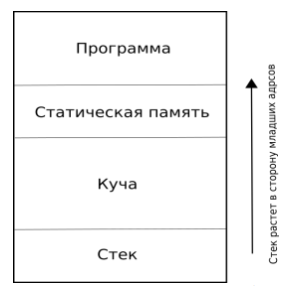

Динамическая память в области кучи выделяется от края статической памяти в сторону больших адресов. Суть в том, что мы можем запрашивать сколько нам памяти нужно, указывая адрес начала нераспределенной кучи. Для этого имеется два системных вызова **brk, sbrk**.

In [ ]:
#include <unistd.h>

int brk(void *addr);
       
void *sbrk(intptr_t increment);

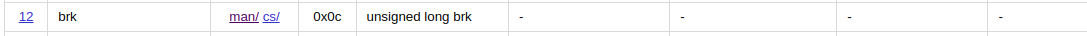

В Linux **sbrk ()** реализован как библиотечная функция, которая использует системный вызов **brk()**.

Названия этих функций происходят из старых UNIX-систем, в которых куча и стек еще находились в одном сегменте памяти. Выделение динамической памяти в куче выполнялось, начиная с нижней части сегмента в сторону увеличения адресов; стек рос из верхней части сегмента, по направлению к куче в сторону уменьшения адресов. **Граница, разделявшая области стека и кучи, называлась остановом или точкой останова**. В современных системах сегмент данных находится в собственном отображении в памяти, но мы по-прежнему именуем конечный адрес отображения точкой останова.

**Вызов brk()** устанавливает точку останова (конец сегмента данных), задавая адрес, указанный в **addr**. В случае успеха функция возвращает адрес новой границы. При ошибке она возвращается код ошибки.

**Вызов sbrk()** приращивает конец сегмента данных на **increment** байт, причем дельта может быть как положительной, так и отрицательной. **sbrk()** возвращает пересмотренную точку останова. 

Соответственно, приращение, равное 0, дает нам актуальную точку останова.

В ассемблере, если вызвать **brk** с **addr = 0**, то также будет возвращено текущее значение точки останова.

In [6]:
#include <stdio.h>
#include <unistd.h>
int main(){
 printf ("Текущая точка останова — %p\n", sbrk (0));
 return 0;
 }

/tmp/tmpjfvjvlpb.c: In function ‘main’:
/tmp/tmpjfvjvlpb.c:4:65: warning: implicit declaration of function ‘sbrk’ [-Wimplicit-function-declaration]
    4 |  printf ("Текущая точка останова — %p\n", sbrk (0));
      |                                                                 ^~~~
/tmp/tmpjfvjvlpb.c:4:59: warning: format ‘%p’ expects argument of type ‘void *’, but argument 2 has type ‘int’ [-Wformat=]
    4 |  printf ("Текущая точка останова — %p\n", sbrk (0));
      |                                                          ~^     ~~~~~~~~
      |                                                           |     |
      |                                                           |     int
      |                                                           void *
      |                                                          %d


Текущая точка останова — 0xfe24c000


В предложенной ниже программе мы получаем адрес начала кучи, потом мы увеличиваем размер кучи на $n$ байт (задается параметром командной строки) и возвращаем полученный адрес точки останова. 

In [ ]:
	format elf64
	public _start
	include 'func.asm'

	section '.bss' writable
	
	buffer_begin rq 1
	buffer_end rq 1
	buffer rb 100

	section '.data' writable
	msg_error db 'kernel can not get memory',0xa,0

	section '.text' executable
	
_start:
	;; Считываем количество параметров командной строки
	pop rcx
	cmp rcx, 2
	jne error

	;; Преобразуем значение из командной строки в число
	mov rsi, [rsp+8]
	call str_number
	mov r8,rax

	;; Получаем начальное значение адреса кучи
	xor rdi,rdi
	mov rax, 12
	syscall
	cmp rax, 0
	jl error
	
	mov [buffer_begin], rax
	

	mov rsi, buffer
	call number_str
	call print_str
	call new_line

	;; Увеличиваем размер кучи на количество, переданное параметром ком. строки
	mov rdi, [buffer_begin]
	
	add rdi, r8
	mov rax, 12
	syscall
	cmp rax, 0
	jl error
	
	mov [buffer_end], rax

	mov rsi, buffer
	call number_str
	call print_str
	call new_line
	
	call exit
error:
	mov rsi, msg_error
	call print_str
	call exit

Ниже продемонстрирована работа данной программы.

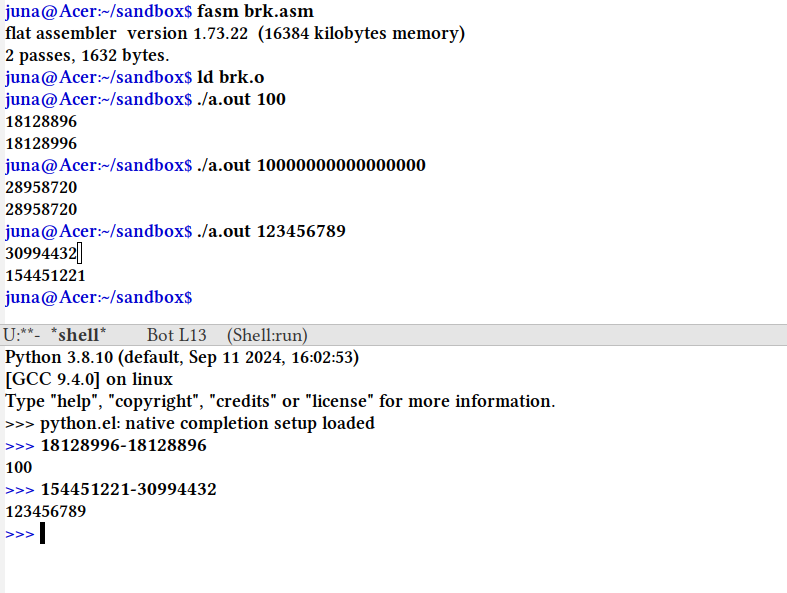

В следующей программе демонстрируется создание стековой структуры в динамической памяти. По каждой команде **pop** с вершины стека снимается и печатается значение, память уменьшается на 1 байт, при каждом **push** - пользователь вводит символ, память увеличивается на 1 байт и в ней сохраняется введенный символ. 

In [ ]:
	format elf64
	public _start
	include 'func.asm'

	section '.bss' writable
	
	buffer_begin rq 1
	buffer_end rq 1
	buffer rb 100

	section '.data' writable
	push_word db "push", 0
	pop_word db "pop", 0
	end_word db "exit",0
	msg_error db 'kernel can not get memory',0xa,0
	msg_input db 'Enter value: ',0
	msg_output db 'Top stack is ',0
	msg_begin db 'Enter command: ',0

	section '.text' executable
	
_start:
	;; Получаем начальное значение адреса кучи
	xor rdi,rdi
	mov rax, 12
	syscall
	cmp rax, 0
	jl error

	mov [buffer_begin], rax
	mov [buffer_end], rax
	
loop_main:
	mov rsi, msg_begin
	call print_str
loop_other:	
	mov rsi, buffer
	call input_keyboard
	mov rdi, push_word
	call equal_string
	cmp rax,1
	je push_action
	mov rdi, pop_word
	call equal_string
	cmp rax,1
	je pop_action
	mov rdi, end_word
	call equal_string
	cmp rax,1
	je end_action
	jmp loop_other

pop_action:
	call new_line
	mov rax, [buffer_begin]
	cmp rax, [buffer_end]
	je loop_main
	mov rsi, msg_output
	call print_str
	mov rdi, 1 
	mov rsi, [buffer_end]
	mov rdx,1
	mov rax, 1
	syscall
	call new_line

	mov rdi, [buffer_end]
	
	sub rdi, 1
	mov rax, 12
	syscall
        cmp rax, 0
	jl error
	mov [buffer_end], rax
	jmp loop_main
	
push_action:
	call new_line
	mov rdi, [buffer_end]
	add rdi, 1
	mov rax, 12
	syscall
	cmp rax, 0
	jl error
	mov rsi, msg_input
	call print_str
	mov [buffer_end], rax
	mov rdi, 0
	mov rsi, [buffer_end]
	mov rdx,1
	mov rax, 0
	syscall
	jmp loop_main
	
end_action:	
	call exit

error:
	mov rsi, msg_error
	call print_str
	call exit

;;; Программа сравнивает строку по адресу rsi
;;; со строкой по адресу rdi
;;; Если они равны, то rax = 1
;;; Если не равны, то rax = 0
;;; input: rsi, rdi - addresses of strings
;;; output rax = 1|0
equal_string:
	mov rax, rsi
	call len_str
	mov r8,rax
	mov rax, rdi
	call len_str
	mov r9,rax
	cmp r8,r9
	jne l1
	xor rcx, rcx
	xor rax,rax
	inc rax
	xor rdx, rdx
pr:
	mov dl, [rsi+rcx]
	cmp dl, [rdi+rcx]
	jne l1
	inc rcx
	cmp rcx, r8
	jle pr
	ret
l1:
	mov rax, 0
	ret

Ниже продемонстрирована работа программы.

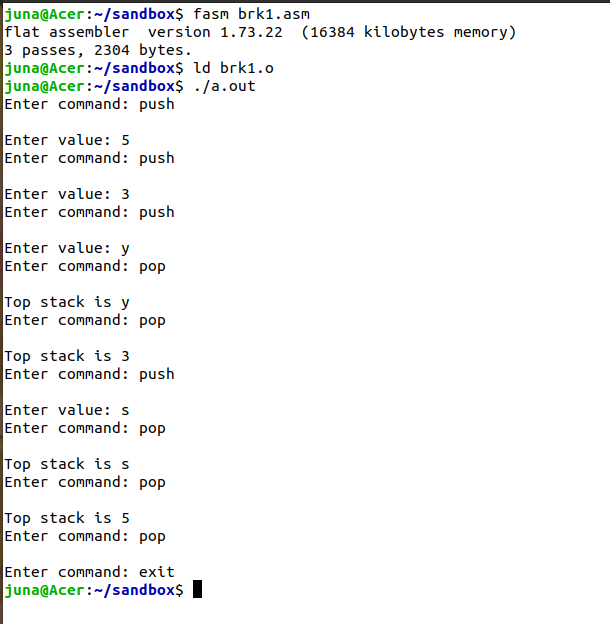

### Анонимные отображения в памяти

Мы уже рассматривали отображение файлов в память - это функции **mmap, munmap**, осуществляющие выделение, очистку памяти соответственно. Однако возникает вопрос - что будет, если в них не указывать файловый дескриптор?

Оказывается, что в этом случае мы получим так называемое **анонимное отображение в памяти**.

**Анонимные отображения в памяти** подобны файловым отображениям, не считая того, что в их основе не лежит какой-либо файл — поэтому они и называются анонимными. На самом деле анонимное отображение в памяти — это просто большой блок памяти, заполненный нулями и готовый к использованию. Можете считать его новоиспеченной кучей, которая будет использоваться в рамках одного выделения в памяти. Такие отображения располагаются вне кучи, поэтому не приводят к дополнительной фрагментации сегмента данных.

При выделении памяти методом анонимных отображений мы имеем следующие преимущества.
- Отсутствуют проблемы, связанные с фрагментацией. Когда программа больше не нуждается в анонимном отображении в памяти, оно удаляется и память немедленно возвращается в систему.
- Можно изменять размер анонимных отображений в памяти, корректировать права доступа к ним, они могут получать извещения, как и обычные отображения.
- Каждое выделение существует в отдельном отображении в памяти. Нет необходимости управлять глобальной кучей. 

При использовании анонимных отображений памяти вместо работы с кучей мы также сталкиваемся с двумя недостатками.
- Размер каждого отображения в памяти делится без остатка на размер страницы, применяемой в системе, поэтому если выделенное пространство не является целочисленным кратным размера страницы, то будет образовываться неиспользуемое «потерянное» пространство. Оно представляет тем большую проблему, чем меньше размер отдельных выделений, где такие «хвосты» получаются относительно крупными по сравнению с полезными областями.
- Создание нового отображения в памяти сопряжено с большим количеством издержек, чем удовлетворение запросов на выделение из кучи, поскольку куча может работать вообще без взаимодействия с ядром. Чем меньше размер выделяемых областей, тем серьезнее издержки.

Для создания анонимного отображения в память вместо файлового дескриптора указывают значение -1, также флаги устанавливают в значение **MAP_ANONYMOUS|MAP_PRIVATE**.

Соответсвие названиям флагом числовых значений задается во все том же заголовочном файле [mmap.h](https://sites.uclouvain.be/SystInfo/usr/include/bits/mman.h.html). 

In [ ]:
MAP_PRIVATE        0x02                /* Changes are private.  */
#ifdef __USE_MISC
# define MAP_TYPE        0x0f                /* Mask for type of mapping.  */
#endif

/* Other flags.  */
#define MAP_FIXED        0x10                /* Interpret addr exactly.  */
#ifdef __USE_MISC
# define MAP_FILE        0
# define MAP_ANONYMOUS        0x20                /* Don't use a file.  */
# define MAP_ANON        MAP_ANONYMOUS
# define MAP_32BIT        0x40                /* Only give out 32-bit addresses.  */

Таким образом, у нас получается **MAP_ANONYMOUS|MAP_PRIVATE = 0x02+0x20 = 0x22**.

Ниже представлена программа, в которой создается анонимное отображение в память, после чего ввод с клавиатуры ассоцируется с этой областью памяти. Для проверки мы также печатаем из этой памяти.


In [ ]:
	format elf64
	public _start
	include 'func.asm'

	volume = 10000
	section '.text' executable
	
_start:
	;; выполняем анонимное отображение в память
	mov rdi, 0    ;начальный адрес выберет сама ОС
	mov rsi, volume ;задаем размер области памяти
	mov rdx, 0x3  ;совмещаем флаги PROT_READ | PROT_WRITE
	mov r10,0x22  ;задаем режим MAP_ANONYMOUS|MAP_PRIVATE
	mov r8, -1   ;указываем файловый дескриптор null
	mov r9, 0     ;задаем нулевое смещение
	mov rax, 9    ;номер системного вызова mmap
	syscall

	mov rsi, rax  ;Сохраняем адрес памяти анонимного отображения
	mov rax, 0
	mov rdi, 0
	mov rdx,  1000
	syscall
	xor rcx, rcx
	.loop:
	mov al, [rsi+rcx]
	inc rcx
	cmp rax, 0x0A
	jne .loop
	dec rcx
	mov byte [rsi+rcx], 0

	call new_line

	call print_str

	call new_line

	;; выполняем системный вызов munmap, освобождая память
	mov rdi, rsi
	mov rsi, volume
	mov rax, 11
	syscall

	call exit

Ниже представлен пример использования данной программы.

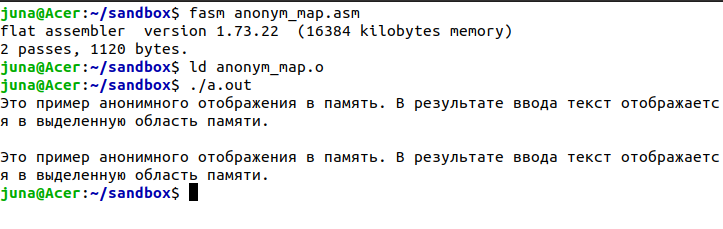

## 2. Сопряжение функционала на языках C и ассемблера.

Из описания системных вызовов мы знаем, что при вызове функции C имеется строгое соответствие номера параметра функции и регистра процессора.

В архитектуре x86-64 это следующее соответствие:
- первый параметр - регистр **rdi**;
- второй параметр - регистр **rsi**;
- третий параметр - регистр **rdx**;
- четвертый параметр - регистр **r10**;
- пятый параметр - регистр **r8**;
- шестой параметр - регистр **r9**.

Может возникнуть естественный вопрос, а как обстоят дела в передачей параметров любой другой функции на языке С, которая будет вызываться из ассемблера? Ответ - точно так же! Только порядок использования регистров немного другой, что будет подробно рассмотрено в следующей лекции.

Единственная сложность при вызове состоит в том, что эту фукцию ассемблер должен найти на этапе компиляции.

Есть два основных способа решить эту проблему:
- компилировать программу на языке С до объектного файла, а потом линковать объекный файл из ассемблера с объектным файлом из С;
- использовать разделяющиеся библиотеки.

Чтобы компилировать программу C до объектного файла и отключить линковку, нужно использовать ключ **-c**. Чтобы ассемблер не ругался на этапе компиляции на неизвестную ему функцию из языка С, ее нужно объявить, используя ключевое слово **extrn**, которое указывает ассемблеру, что эта внешняя функция будет добавлена на этапе линковки.

Нужно также следить за совпадением типов аргументов функции C и разрядностью передаваемых данных на ассемблере. Приведенный код показывает, сколько байт занимают некоторые типы данных C:

In [1]:
#include<stdio.h>

int main(){
  printf("char: %ld bytes\n",sizeof(char));
  printf("int: %ld bytes\n",sizeof(int));
  printf("long int: %ld bytes\n",sizeof(long int));
  printf("long long int: %ld bytes\n",sizeof(long long int));
  printf("unsigned int: %ld bytes\n",sizeof(unsigned int));
  printf("unsigned long: %ld bytes\n",sizeof(unsigned long));
  printf("unsigned long long: %ld bytes\n",sizeof(unsigned long long));
  return 0;
}

char: 1 bytes
int: 4 bytes
long int: 8 bytes
long long int: 8 bytes
unsigned int: 4 bytes
unsigned long: 8 bytes
unsigned long long: 8 bytes


Ниже рассмотрен простейший пример: мы пишем на языке С простейшую функцию, которая суммирует два целых числа. На языке асемблера мы вызываем эту функцию и печатаем результат на экран. Числа, которые нужно просуммировать, мы передаем параметрами командной строки.

In [ ]:
//Программа на С sum.c
int sum(int a, int b){
  return a+b;
}

In [ ]:
;;Программа на ассемблере call_sum.asm
	format elf64

	public _start

	extrn sum

	include "func.asm"

	section ".data" writable

	buffer dq 1
section ".text" executable
_start:
	pop rcx
	cmp rcx, 3
	jne .l1
	mov rsi, [rsp+8]
	call str_number
	mov rdi, rax
	mov rsi, [rsp+16]
	call str_number
	mov rsi, rax
	call sum
	mov rsi, buffer
	call number_str
	call print_str
	call new_line
.l1:
	call exit


Ниже приведен пример совместной компиляции и использования данных программ:

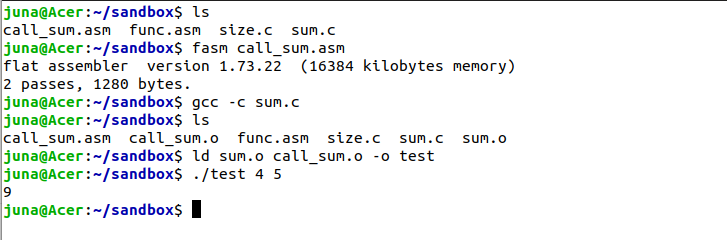

Обратите внимание, что при линковке мы указываем два объектных файла: call_sum.o (который был получен fasm), sum.o (который был получен компилятором gcc).

Аналогично можно выполнить обратные действия - написать функцию на ассемблере и вызвать ее из программы на языке С.

Ниже представлены программы на С и ассемблере. На ассемблере мы пишем функцию нахождения разности двух чисел, а на С вызываем эту функцию.

In [ ]:
//Программа на С call_sub.c
#include<stdio.h>

int sub(int, int);

int main(){
  int a,b;
  scanf("%d", &a);
  scanf("%d", &b);
  printf("%d\n",sub(a,b));
  return 0;
}

На языке C мы указываем прототип функции, но не пишем реализацию самой функции. Эта реализация будет взята на этапе линковки из объектного файла на языке ассемблера.

In [ ]:
;;Программа на ассемблере sub.asm
format elf64

public mysub

mysub:
      mov rax, rdi
      sub rax, rsi
      ret

Ниже представлен скриншот, демонстрирующий совместное использование C и ассемблера:

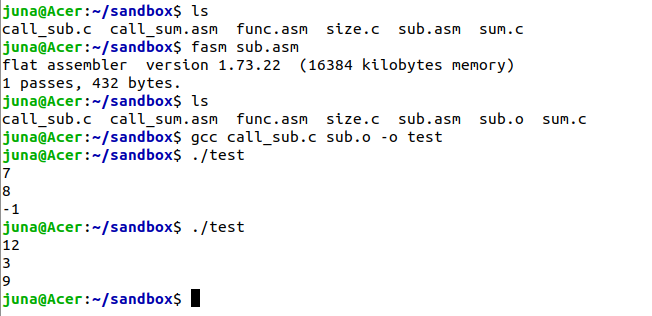

Обратите внимание, что линковать файлы здесь лучше **gcc**, поскольку **ld** ищет стандартную точку входа в программу **_start**. Кроме того, нужно указывать, где искать библитечные функции scanf, printf:

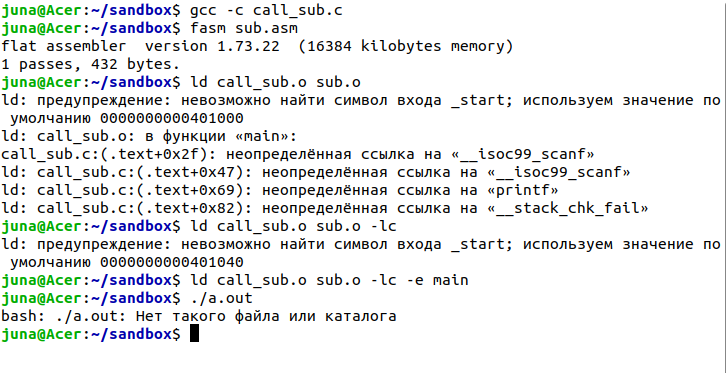

## 3. Утилита make

Когда программа состоит из множества различных модулей, часто приходится выполнять однообразую и объемную работу по их компиляции и сопряжению. В этом случае на помощь приходит утилита make, которая позволяет автоматизировать процесс сборки сложного проекта, состоящего из отдельных модулей. 

Например, в наших примерах выше мы сначала создавали объектный файл компилятором fasm, потом компилятором gcc, а потом их линковали с помощью ld.

**Утилита make работает с файлом Makefile. Данный файл должен находиться в каталоге, из которого доступны все сопрягаемые модули.**

Файл Makefile имеет специальный формат, состоящий из **целей**. Каждая цель пишется с новой строки и обозначается словом, которое будет потом вызываться совместно с утилитой make. После имени цели ставится двоеточие, после которого перечисляются файлы, используемые для достижения цели, в качестве таких имен можно применять имена других целей, если для реализации искомой цели необходимо вначале получить результат этих других целей. Далее после названия цели, двоеточия и перечисления файлов и целей с новой строки и обязательного одного знака табуляции необходимо написать перечень команд, которые будут выполняться для достижения результата цели. 

Рассмотрим в качестве примера, как бы мог выглядеть файл сопряжения программ на ассемблере и С, рассмотренные выше. Фактически нам приходилось делать четыре отдельных запуска:
1. Создавать объектный файл: fasm call_sum.asm
2. Создавать объектный файл: gcc -c sum.c -o -sum.o
3. Линковать полученные объектные файлы: ld sum.o call_sum.o -o myprog
4. Запускать программу с параметрами: ./myprog 7 8

Makefile позволяет сделать это одной командой:

In [ ]:
sum_asm: call_sum.asm
	fasm call_sum.asm

sum_c: sum.c
	gcc -c sum.c -o sum.o

build: sum_asm sum_c
	ld sum.o call_sum.o -o myprog

run: build myprog
	./myprog $(var)

clean:
	rm -f *.o

Как видно из Makefile, имеется пять целей, имена которых: sum_asm, sum_c, build, run, clean. Таким образом,  утилиту make можно запускать со следующими командами:

    >make sum_asm

В результате данной команды будет создан объектный файл call_sum.o.
  
    >make sum_c

В результате данной команды будет создан объектный файл sum.o.

    >make build

В результате данной команды будет создан исполняемый файл myprog.

    >make run var="8 9"

В результате данной команды будет создан исполняемый файл myprog. Поскольку для реализации этой цели указаны все предыдущие цели, то, если объектные файлы отсутствуют, они будут созданы, т.е. соответствующая цель будет достигнута перед реализацией основной цели.
 
    >make clean

В результате данной команды все созданные в данной директории объектные файлы будут удалены.
  

В целом утилита make - очень гибкое и удобное средство, получить ее более подробное описание можно из других источников (например, Столяров А. В. Программирование: введение в профессию II: Низкоуровневое программирование. М.: Макс-Пресс, 2016, 496 с.).

Ниже представлены примеры работы с Makefile:

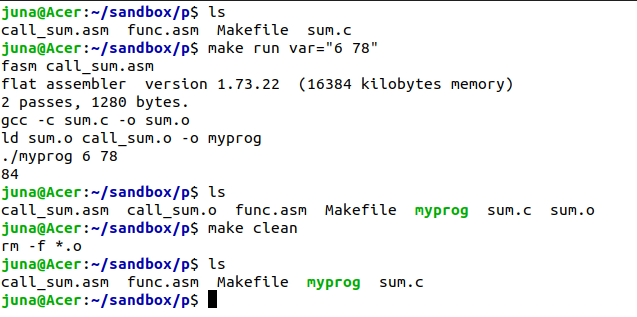

Ниже в качестве примера на языке ассемблера создана функция, выделяющая динамическую память под массив значений в количестве, заданных пользователем. Количество значений задается в программе на языке C. В дальнейшем продемонстрирована работа с выделенной памятью с помощью индексации массива из программы на С. 

In [ ]:
	format elf64

	public create_array
	public free_memory

	section '.data' writable

	section '.bss' writable

	array_begin rq 1
	count rq 1

create_array:
	mov [count], rdi
	;; Получаем начальное значение адреса кучи
	xor rdi,rdi
	mov rax, 12
	syscall
	mov [array_begin], rax
	mov rdi, [array_begin]
	add rdi, [count]
	mov rax, 12
	syscall
	mov rax, array_begin
	ret

free_memory:
	xor rdi,[array_begin]
	mov rax, 12
	syscall
	ret

In [ ]:
#include<stdio.h>

unsigned long * create_array(unsigned long);
unsigned long * free_memory();

int main(){
  unsigned long *p, n;
  scanf("%ld",&n);
  p = create_array(n);
  p[0] = 8;
  p[1] = 7;
  p[2] = p[0]+p[1];
  printf("%ld\n",p[2]);
  free_memory();
  return 0;
}

In [ ]:
asm: stat_array.asm
        fasm stat_array.asm

c: asm stat_array.c
        gcc stat_array.c stat_array.o -o myprog

run: c myprog
        ./myprog

clean:
        rm -f *.o


Ниже продемонстрирована работоспособность приложений:

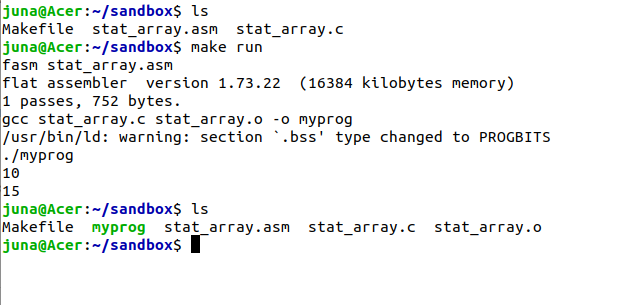